In [1]:
import openslide
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL
import cv2
from scipy.ndimage import sobel
from skimage.filters import threshold_otsu
from packages.utils import get_list_of_paths
from packages.wsi_prep import get_tissue_mask, get_tiles

## Tiling Demo

Here we demonstrate how the tissue mask generation and tiling function.


In [2]:
slide_paths = get_list_of_paths('/Volumes/BurhanAnisExtDrive/camelyon/camelyon_data/training/negative') #get all slide paths from the negative training images

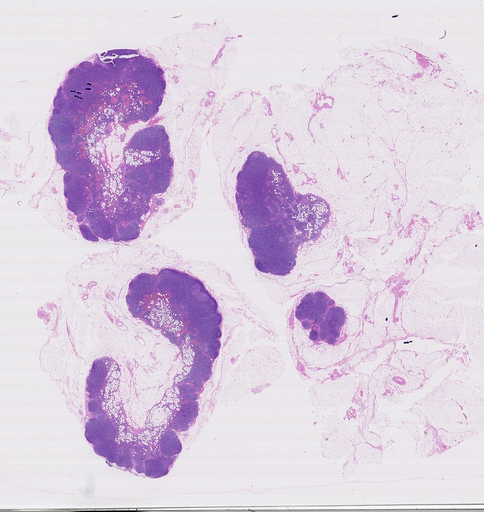

In [3]:
#pick a random image to segment and tile
idx = np.random.randint(0, len(slide_paths))
path = slide_paths[idx]
slide = openslide.OpenSlide(path)
slide.get_thumbnail([512, 512])

## Tissue mask generation:

We convert the image at some downsampled level into a numpy array and then convert to grayscale by averaging across colour channels (ignoring the alpha channel, if present). We then use the sobel operator to calculate gradient magnitudes in horizontal and vertical directions, then threshold the magnitudes using otsu's method. This generates the tissue mask.

In [4]:
mask_level = 7

mask_dims = slide.level_dimensions[mask_level]
mask_width, mask_height = mask_dims
mask_image = slide.read_region((0, 0), mask_level, mask_dims)
mask_np = np.array(mask_image, copy=False)

if mask_np.shape[2] > 3:
    mask_np = mask_np[:, :, :3] #ignore alpha channel

gray_mask = np.mean(mask_np.astype(np.float32), axis = 2)

# Compute gradient magnitude to identify tissue
grad_x = sobel(gray_mask, axis=1)
grad_y = sobel(gray_mask, axis=0)
magnitude = np.sqrt(grad_x**2 + grad_y**2)

# Threshold to create a tissue mask
threshold_value = threshold_otsu(magnitude)
threshold_value = threshold_value - 0.5*threshold_value
tissue_mask = magnitude > threshold_value

Text(0.5, 1.0, 'Gray Scale Image')

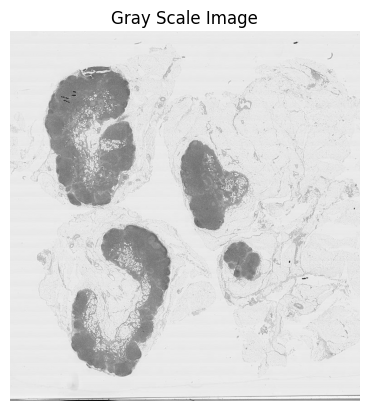

In [5]:
plt.imshow(gray_mask, cmap = 'gray')
plt.axis('off')
plt.title('Gray Scale Image')

Text(0.5, 1.0, 'Gradient Magnitude')

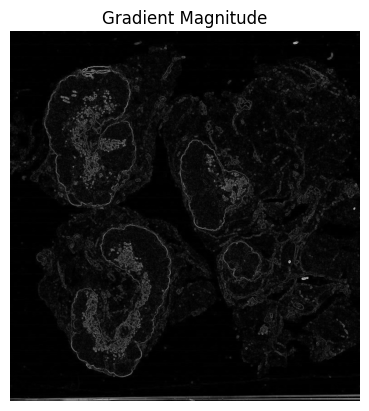

In [6]:
plt.imshow(magnitude, cmap = 'gray')
plt.axis('off')
plt.title('Gradient Magnitude')

Text(0.5, 1.0, 'Binary Tissue Mask')

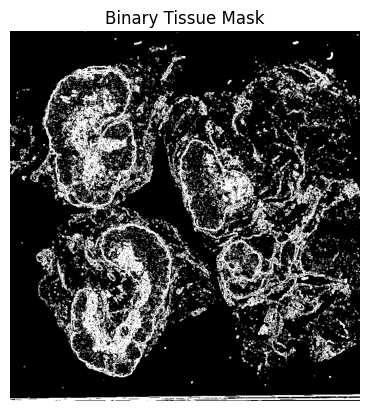

In [7]:
plt.imshow(tissue_mask, cmap='gray')
plt.axis('off')
plt.title('Binary Tissue Mask')

## Tiling:

Next we tile the image in a non-overlaping way

In [8]:
patch_size = 64
positions = []
step_size = patch_size  # Non-overlapping patches
for y in range(0, tissue_mask.shape[0] - patch_size + 1, step_size):
    for x in range(0, tissue_mask.shape[1] - patch_size + 1, step_size):
        patch = tissue_mask[y:y+patch_size, x:x+patch_size]
        # Check if the patch contains sufficient tissue
        if np.sum(patch) > (0.02 * patch_size * patch_size):  # Keeping any tiles with 2% tissue coverage
            positions.append((x, y))


In [9]:
len(positions)

117

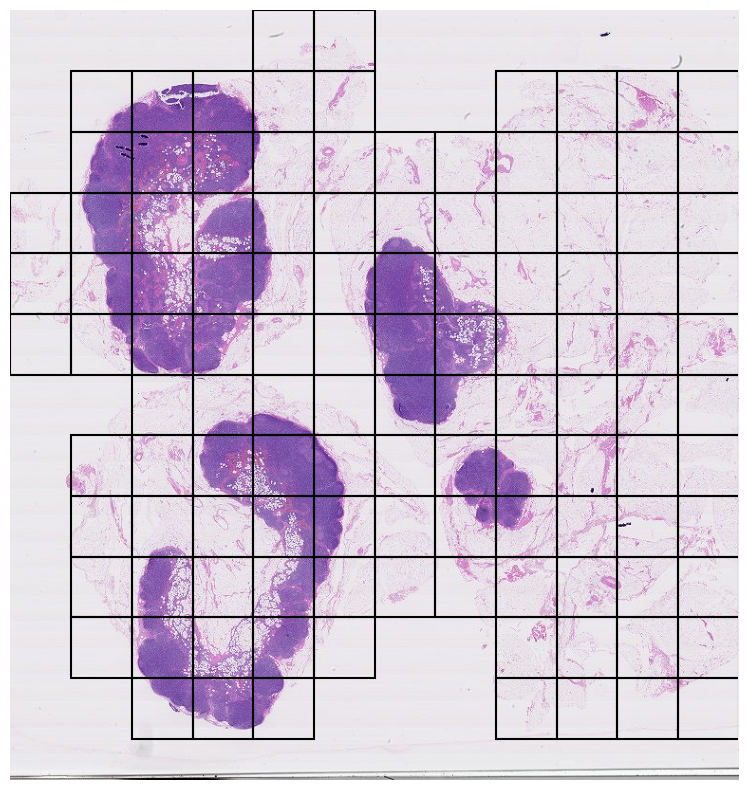

In [10]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mask_np)
ax.axis('off')

# Overlay tiles
for coord in positions:
    x, y = coord

    # Add a rectangle to the plot
    rect = patches.Rectangle(
        (x, y),  # Top-left corner
        patch_size ,  # Width
        patch_size ,  # Height
        linewidth=1.5,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.show()

We performed Tiling at a downsampled level, so we need to map the coordinates back to level 0 and adjust patch size accordingly. In **`wsi_prep.py`** we do this in reverse - ie, we have a desired a patch size for level 0 and so calculate a patch size for the downsampled level accordingly.

In [11]:
# Get the downsampling factor for the selected level
downsample_factor = slide.level_downsamples[mask_level]

# Convert positions to original image coordinates
positions_level0 = [(int(x * downsample_factor), int(y * downsample_factor)) for (x, y) in positions]

# Adjust the patch size to the original resolution
patch_size_level0 = int(patch_size * downsample_factor)

Plotting the Tiles at some arbritrary (non-0) level so show that the mapping has worked.

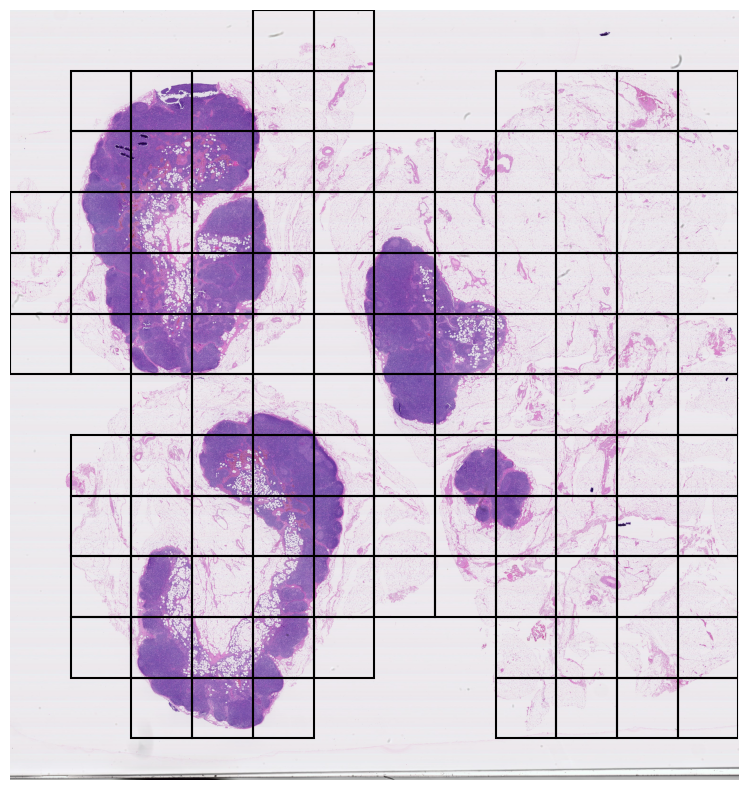

In [12]:
level = 5
width, height = slide.level_dimensions[level]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.array(slide.read_region([0,0], level, slide.level_dimensions[level])))
ax.axis('off')
downsample_factor = slide.level_downsamples[level]

# Overlay tiles
for coord in positions_level0:
    x, y = coord
    # Scale coordinates to the specified level
    x_level = int(x / downsample_factor)
    y_level = int(y / downsample_factor)

    # Add a rectangle to the plot
    rect = patches.Rectangle(
        (x_level, y_level),  # Top-left corner
        patch_size_level0 / downsample_factor,  # Width
        patch_size_level0 / downsample_factor,  # Height
        linewidth=1.5,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.show()


In [13]:
slide.close()